In [ ]:
#import libraries

import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

try:
    import yahoo_fin.stock_info as si
except:
    !pip install yahoo_fin
    import yahoo_fin.stock_info as si

%matplotlib inline
warnings.filterwarnings("ignore")

stock_name = "AAPL"
End_Date = dt.datetime.now()
Start_Date = End_Date.replace(year=End_Date.year-1)

In [ ]:
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# download the data fromm yahoo fin
yf_data = si.get_data(stock_name, start_date= Start_Date, end_date= End_Date, index_as_date = True, interval = "1d")

# pre process
data_frame = pd.DataFrame(data=yf_data)
data_frame['close'].fillna(method='ffill')

# get close data
close_data_frame = data_frame.filter(['close'])
close_data = close_data_frame.values

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_data = scaler.fit_transform(close_data)

# get training data
training = int(np.ceil(len(close_data) * .80)) 
train_data = scaled_close_data[0:int(training), :]

# prepare feature and labels
x_train = []
y_train = []

# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)
n_features = 1   # number of features

In [ ]:
for i in range(n_lookback, len(train_data),1):
    x_train.append(train_data[i-n_lookback:i])
    y_train.append(train_data[i])

# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_features))

In [ ]:
# Build the LSTM model
model = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
model.add(keras.layers.LSTM(units=30, activation = 'relu', return_sequences=True, input_shape= (x_train.shape[1], 1)))
# Adding the Second Third hidden layer and the LSTM layer
model.add(keras.layers.LSTM(units=30, return_sequences=False))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=100,verbose=0 ) 

In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002

test_data = scaled_close_data[training - n_lookback: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = close_data[training:, :]

for i in range(n_lookback, len(test_data)):    
    x_test.append(test_data[i-n_lookback:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_features ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2)) 
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)

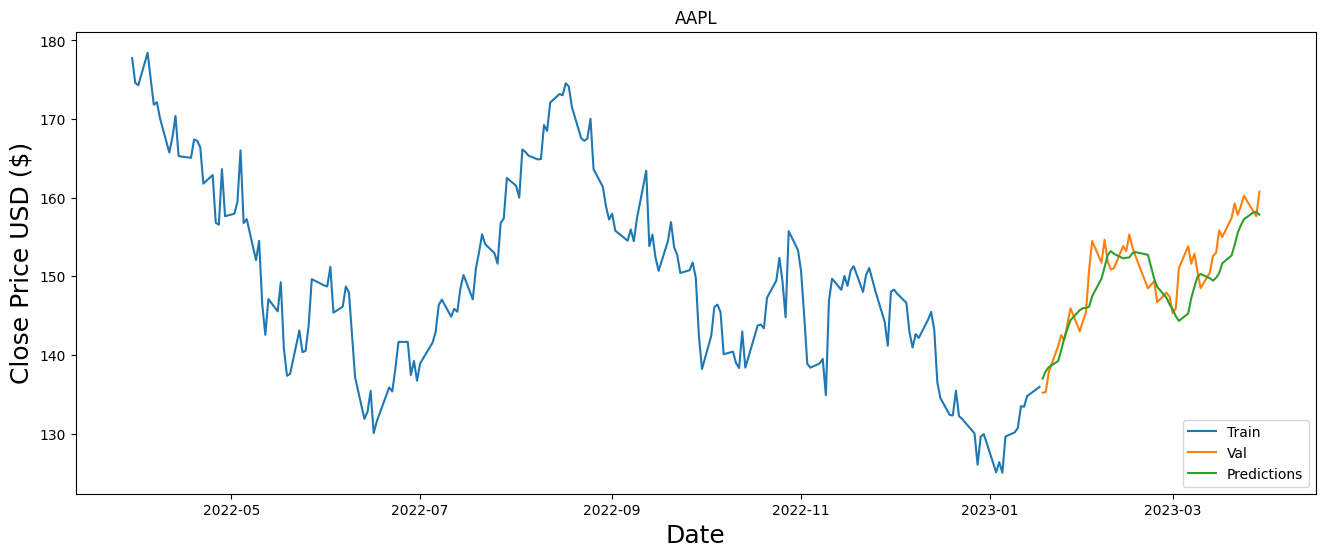

In [ ]:
# Plot the data
train = close_data_frame[:training]
valid = close_data_frame[training:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title(stock_name)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Show the valid and predicted prices
valid.shape

In [ ]:
# Create the data sets x_predict and y_predict
seed_batch = scaled_close_data[:n_lookback].reshape((1,n_lookback, n_features))
date_list = np.array([])
y_predict_list = []

current_batch = seed_batch
last_date = pd.to_datetime(data_frame.index[-1])

for i in range(1, n_forecast+1):    
    y_predict = model.predict(current_batch)[0]    
    y_predict_list = np.append(y_predict_list , y_predict)
    current_batch = np.append(current_batch[:,1:,:],[[y_predict]],axis=1)
    last_date += dt.timedelta(days=1)
    date_list = np.append(date_list , last_date )

y_predict_list =scaler.inverse_transform(y_predict_list.reshape(-1, 1))

[135.98999445777008, 137.0671418159211, 137.69784208726117, 138.15772121753275, 138.55036450859006, 138.9136776424025, 139.25836708954876, 139.58544538761817, 139.89278238677662, 140.17761748925705, 140.43734770927563, 140.66978717559005, 140.87327220615498, 141.04661354691507, 141.1891138842475, 141.3005598847608, 141.38111075247843, 141.4313746467701, 141.45225903056962, 141.44505027238665, 141.41131334777197, 141.3528504462713, 141.27173440427032, 141.17014313281015, 141.05046946836364, 140.9151508245302, 140.76678700301318, 140.60787909902137, 140.44102691425815, 140.2686535339608]


<Axes: xlabel='TradeDate'>

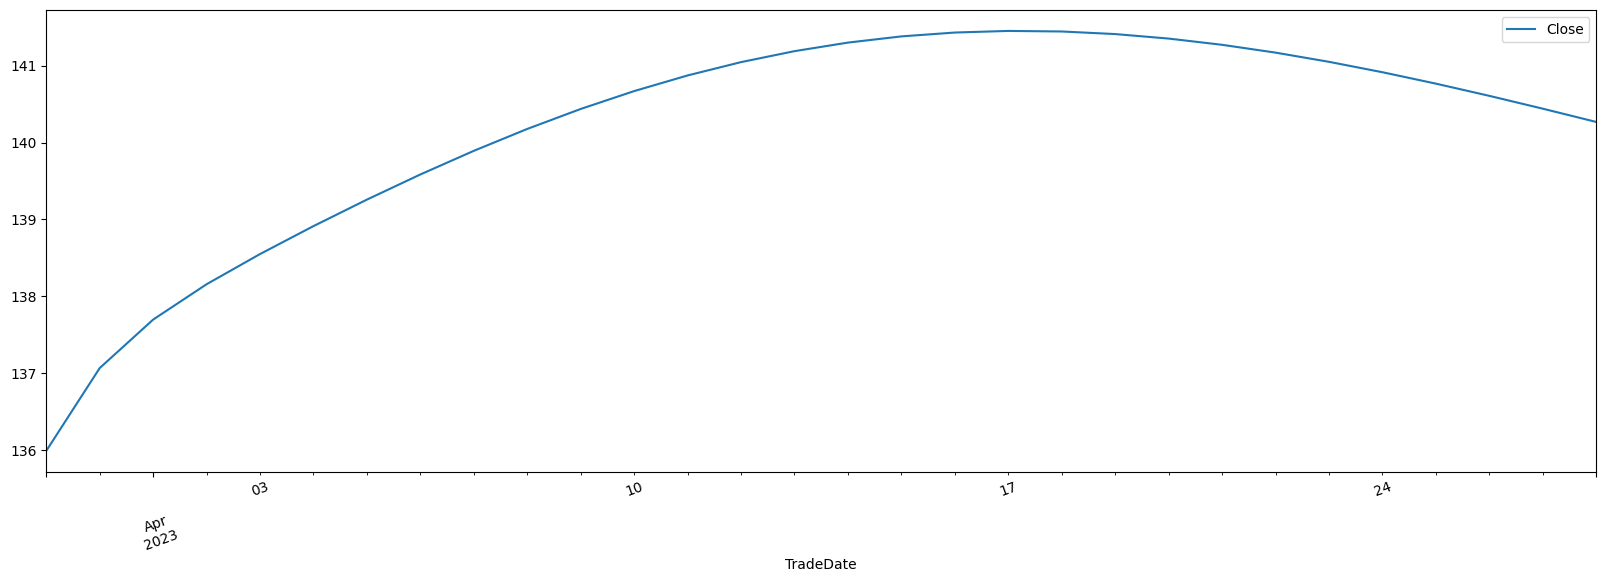

In [ ]:
Forecast_array =  np.ndarray.tolist(y_predict_list.flatten())
Forecast_Data = pd.DataFrame(data = {'TradeDate' : date_list , 'Close' : Forecast_array })

# Plot
%matplotlib inline
Forecast_Data.plot(x='TradeDate', y='Close', kind='line', figsize=(20,6), rot=20)